In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# Get a list of column names and types for measurements table
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c['type'])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
engine.execute('SELECT * FROM measurement LIMIT 3').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0)]

In [13]:
# Get a list of column names and types for Station table
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c['type'])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
engine.execute('SELECT * FROM station LIMIT 3').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)]

# Exploratory Climate Analysis

In [15]:
# Earliest Date
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [26]:
# Latest Date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
latest_date

'2017-08-23'

In [28]:
# Calculate the date 1 year ago from the last data point in the database
yr_ago = dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)
yr_ago

datetime.datetime(2016, 8, 23, 0, 0)

In [33]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

lastyrs_precip = session.query(Measurement.date,(Measurement.prcp)).\
        filter(Measurement.date >= yr_ago).\
        group_by(Measurement.date).all()
lastyrs_precip

[('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06', 0.0),
 ('2016-10-07'

In [34]:
#Create dataframe for lastyrs_precip data
precip_df = pd.DataFrame(lastyrs_precip, columns=['Date', 'Precipitation'])
precip_df.set_index('Date', inplace=True)
precip_df.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


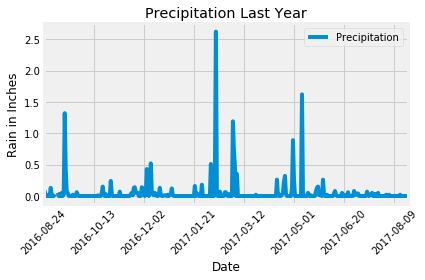

In [61]:
#Plot last year's data
precip_df.plot(y='Precipitation', use_index=True)
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Last Year")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [62]:
# Perform a query to retrieve the data and precipitation scores
precip_df.describe()

,Precipitation
count,363.000000
mean,0.048843
std,0.205197
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


In [68]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [69]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_data = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
stations_data

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [74]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
mostactive_station = stations_data[0][0]
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == mostactive_station).all()

[(54.0, 85.0, 71.66378066378067)]

In [75]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station. and plot the results as a histogram
hi_temp_observ = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == mostactive_station).\
                filter(Measurement.date >= yr_ago).all()
temp_df = pd.DataFrame(hi_temp_observ)
temp_df.set_index('station', inplace=True)
temp_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0
USC00519281,73.0


<function matplotlib.pyplot.show(*args, **kw)>

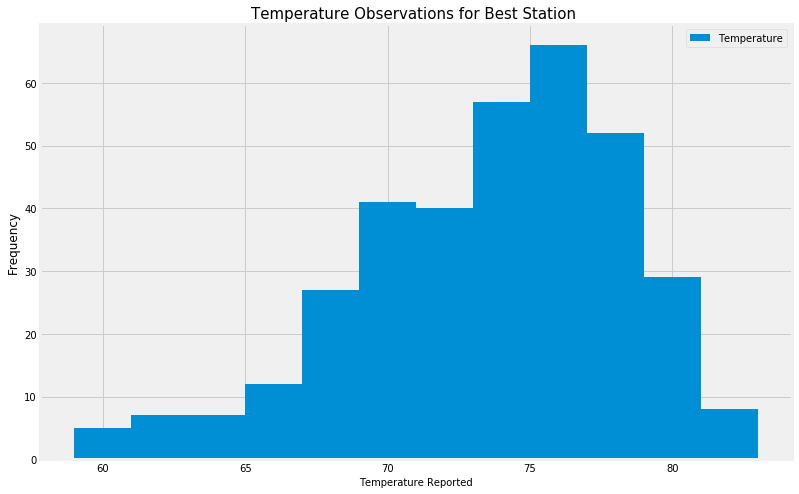

In [81]:
#Plot the results as a histogram
temp_df.plot.hist(by='station', bins=12, figsize=(12,8))
plt.grid(True)
plt.title("Temperature Observations for Best Station ", fontsize=15)
plt.xlabel("Temperature Reported", fontsize=10)
plt.legend(['Temperature'])
plt.show

In [88]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
trip_start = '2017-07-09'
trip_end= '2017-07-15'

def calc_temps(start_date, end_date):
    calc_results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                    filter(Measurement.date >= start_date).\
                    filter(Measurement.date <= end_date).all()
    return calc_results

trip_results = calc_temps(trip_start,trip_end)
trip_results

[(69.0, 78.45652173913044, 82.0)]

In [89]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prevYr_start=dt.datetime.strptime(trip_start, '%Y-%m-%d') - dt.timedelta(days=365)
prevYr_end =dt.datetime.strptime(trip_end, '%Y-%m-%d') - dt.timedelta(days=365)

prev_yr_trip_results = calc_temps(prevYr_start,prevYr_end)
prev_yr_trip_results

[(71.0, 77.1, 82.0)]

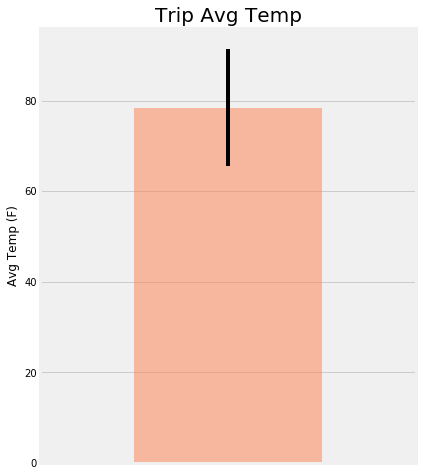

In [91]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Avg Temp (F)")
plt.xticks([])
plt.grid(True)
plt.show()


In [93]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
Tot_Precip_Station = session.query(Measurement.station, func.sum(Measurement.prcp)).\
                       filter(Measurement.date>=prevYr_start).filter(Measurement.date<=prevYr_end).\
                       group_by(Measurement.station).\
                       order_by(func.sum(Measurement.prcp).desc()).\
                       all()  
Tot_Precip_Station

for each in Tot_Precip_Station: print(each[0],"\t",each[1])

USC00516128 	 4.28
USC00519281 	 1.7800000000000002
USC00513117 	 1.02
USC00514830 	 1.01
USC00519523 	 0.86
USC00519397 	 0.48000000000000004
USC00517948 	 None
